In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer

# Load the data
file_path = 'data/vehicles.csv'
vehicles_data = pd.read_csv(file_path)



In [36]:
# Drop NaN values in 'price' column
vehicles_data.dropna(inplace=True)





# Identify and drop columns with high percentage of missing values
missing_values = vehicles_data.isnull().mean() * 100
columns_to_drop = missing_values[missing_values > 50].index.tolist()
vehicles_data_cleaned = vehicles_data.drop(columns=columns_to_drop)

# Drop rows with missing values in 'price' column
vehicles_data_cleaned = vehicles_data_cleaned.dropna(subset=['price'])

# Drop  rows with missing values in 'year' column
vehicles_data_cleaned = vehicles_data_cleaned.dropna(subset=['year'])



In [37]:

# Imputation for remaining columns
categorical_cols = ['condition', 'cylinders', 'fuel', 'transmission', 'drive', 'type', 'paint_color', 'manufacturer']
numerical_cols = ['year', 'odometer']
categorical_imputer = SimpleImputer(strategy='most_frequent')
numerical_imputer = SimpleImputer(strategy='median')


In [38]:
# Dislay unique values in categorical columns

for col in categorical_cols:
    print(f'{col}: {vehicles_data_cleaned[col].unique()}')
    

    
    

condition: ['like new' 'excellent' 'fair' 'good' 'new' 'salvage']
cylinders: ['6 cylinders' '4 cylinders' '8 cylinders' '5 cylinders' '10 cylinders'
 '3 cylinders' 'other' '12 cylinders']
fuel: ['gas' 'hybrid' 'diesel' 'other' 'electric']
transmission: ['automatic' 'manual' 'other']
drive: ['rwd' 'fwd' '4wd']
type: ['van' 'sedan' 'convertible' 'truck' 'coupe' 'SUV' 'hatchback' 'wagon'
 'pickup' 'other' 'mini-van' 'offroad' 'bus']
paint_color: ['white' 'blue' 'silver' 'red' 'grey' 'black' 'brown' 'green' 'custom'
 'yellow' 'orange' 'purple']
manufacturer: ['chevrolet' 'toyota' 'bmw' 'mazda' 'ford' 'mercedes-benz' 'ferrari'
 'lexus' 'audi' 'mitsubishi' 'infiniti' 'nissan' 'volkswagen' 'honda'
 'ram' 'hyundai' 'fiat' 'cadillac' 'jeep' 'gmc' 'jaguar' 'volvo' 'dodge'
 'kia' 'chrysler' 'subaru' 'acura' 'mini' 'buick' 'rover' 'lincoln'
 'porsche' 'saturn' 'harley-davidson' 'pontiac' 'mercury' 'tesla'
 'alfa-romeo' 'datsun' 'land rover' 'aston-martin']


In [39]:
# Outlier removal based on IQR for price and odometer
def calculate_iqr(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    return Q1 - 1.5 * IQR, Q3 + 1.5 * IQR

In [40]:
price_bounds = calculate_iqr(vehicles_data_cleaned['price'])
odometer_bounds = calculate_iqr(vehicles_data_cleaned['odometer'])

In [41]:
filtered_vehicles = vehicles_data_cleaned[
    (vehicles_data_cleaned['price'] <= price_bounds[1]) &
    (vehicles_data_cleaned['odometer'] <= odometer_bounds[1])
    ]


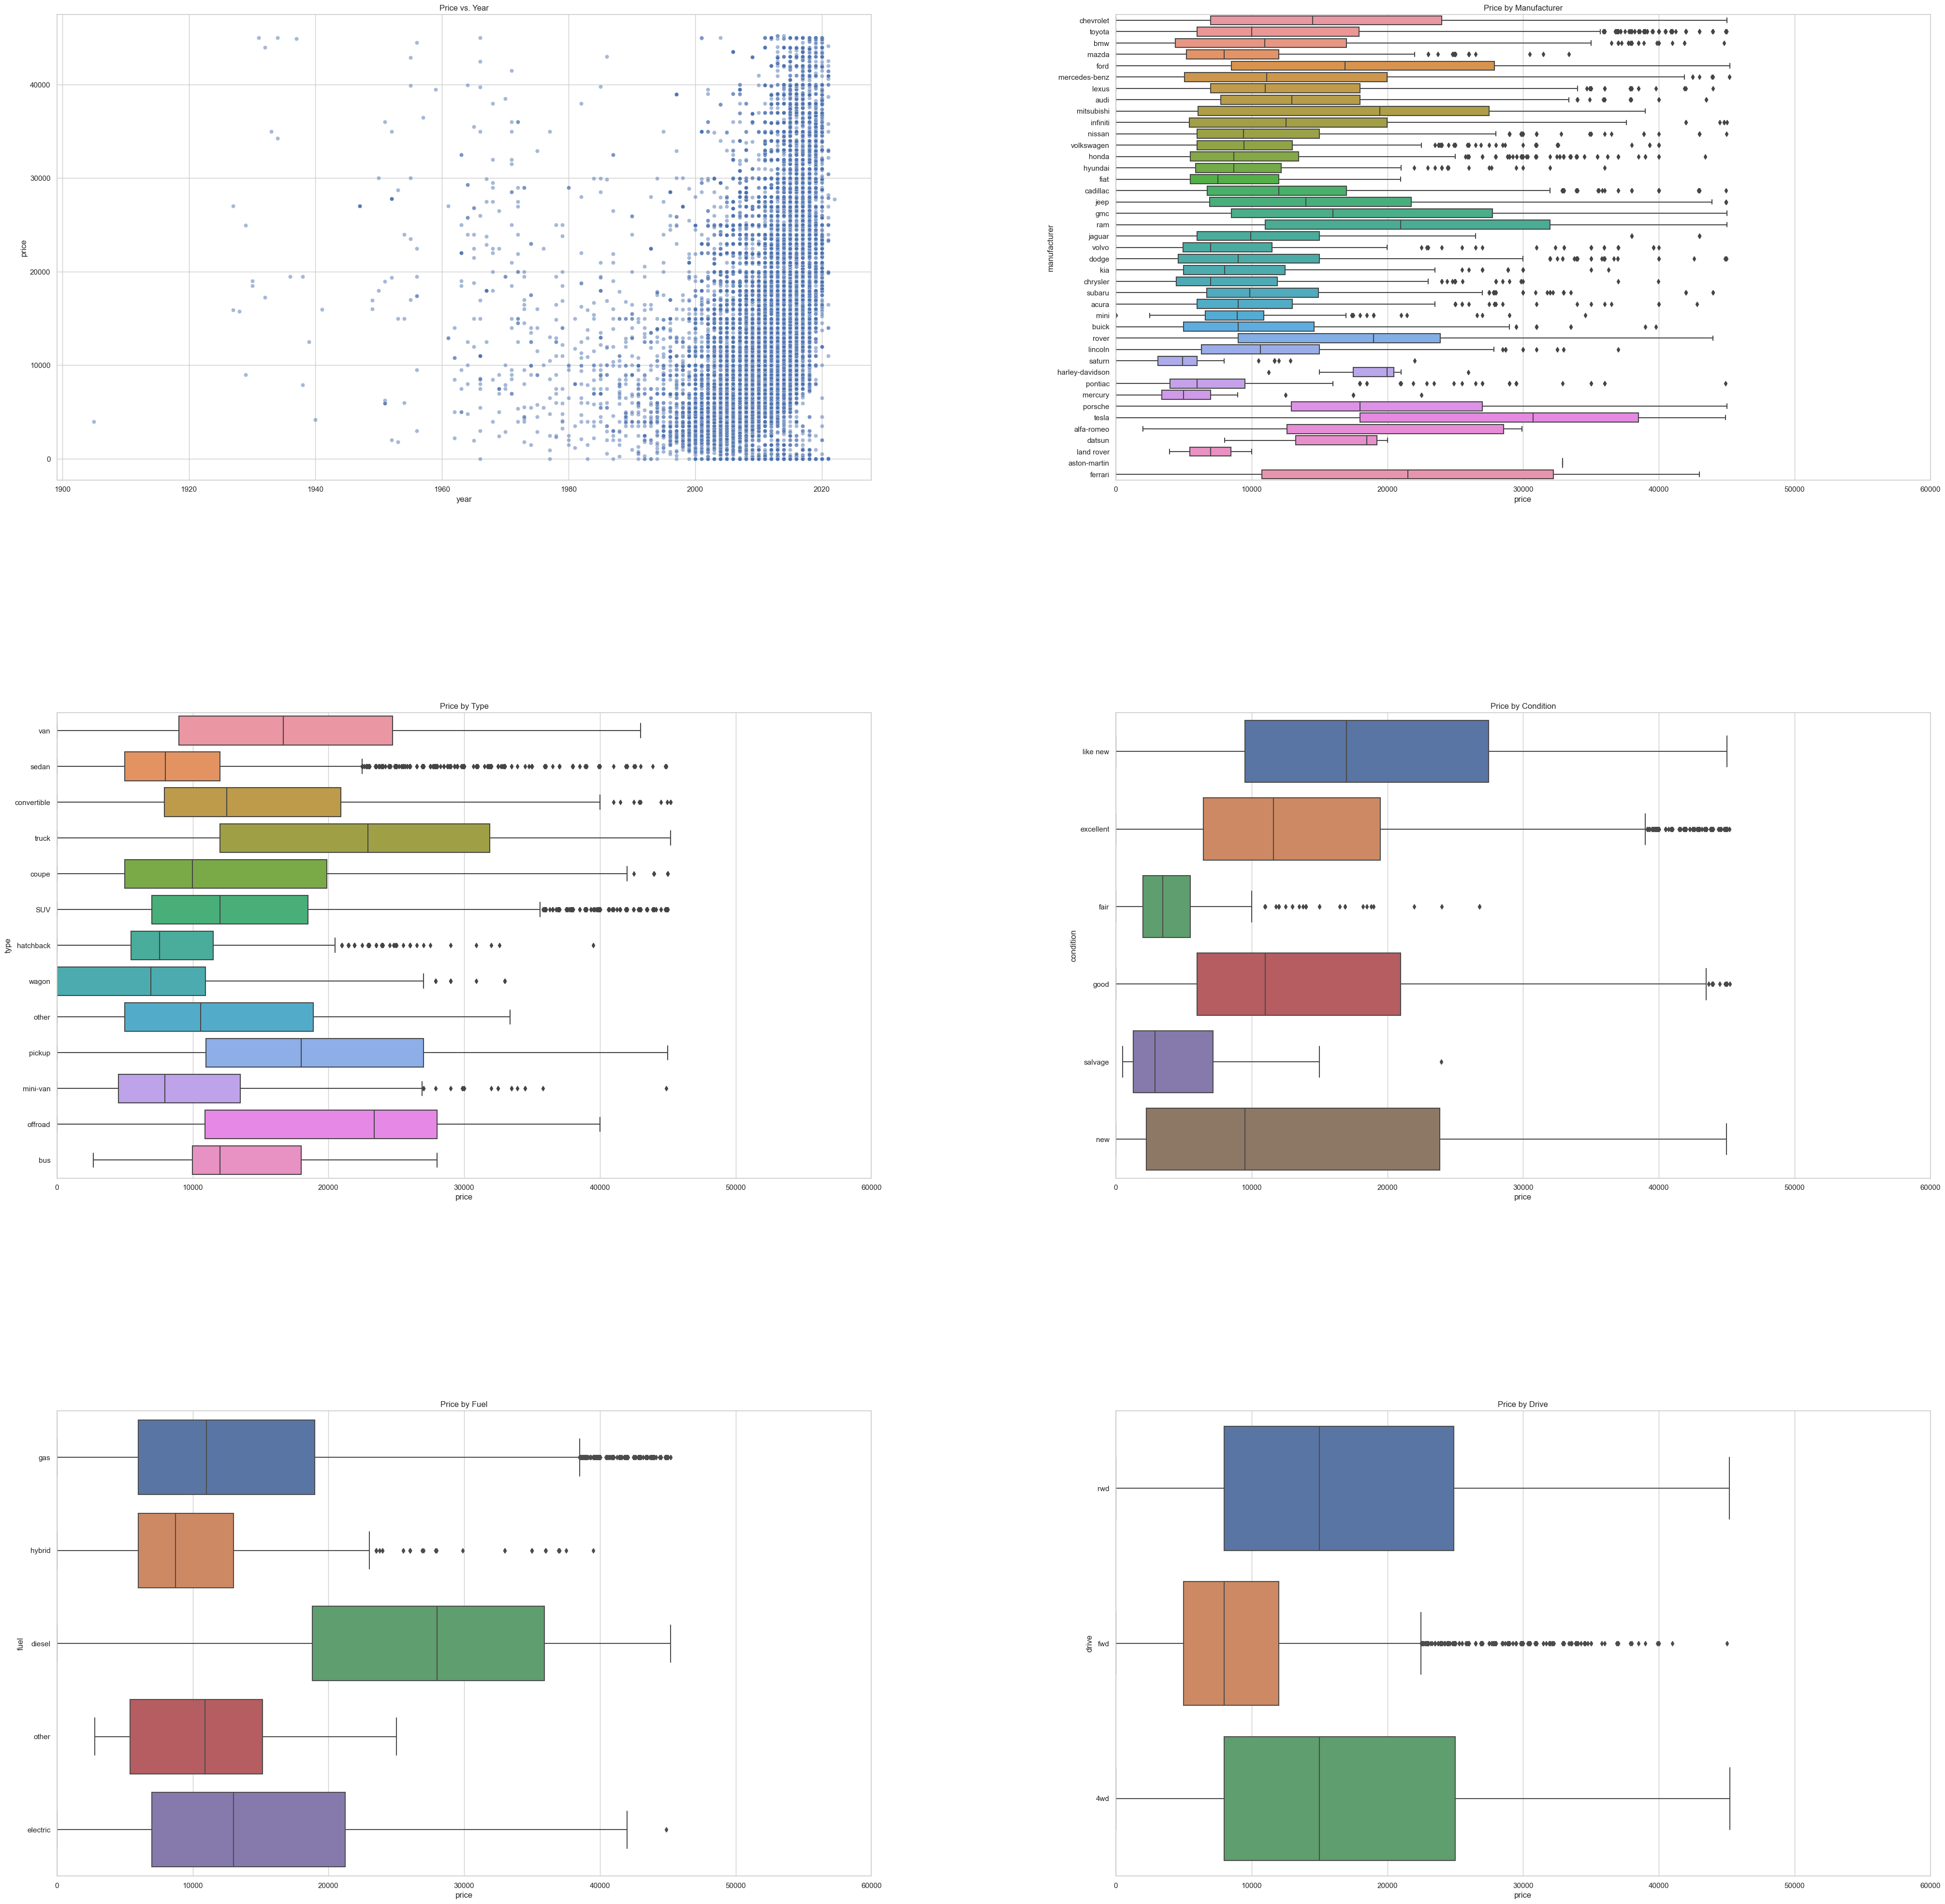

In [42]:
# EDA: Visualizing relationships between features and price
sns.set(style="whitegrid")
fig, axes = plt.subplots(3, 2, figsize=(50, 50))
fig.subplots_adjust(hspace=0.5, wspace=0.3)

# Scatter plot for Year vs Price
sns.scatterplot(ax=axes[0, 0], x='year', y='price', data=filtered_vehicles, alpha=0.5)
axes[0, 0].set_title('Price vs. Year')

# Box plots for various categorical features
plot_data = [
    ('manufacturer', axes[0, 1]),
    ('type', axes[1, 0]),
    ('condition', axes[1, 1]),
    ('fuel', axes[2, 0]),
    ('drive', axes[2, 1])
]
for col, ax in plot_data:
    sns.boxplot(ax=ax, x='price', y=col, data=filtered_vehicles, orient='h')
    ax.set_title(f'Price by {col.capitalize()}')
    ax.set_xlim([0, 60000])

plt.show()

In [43]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Create a column transformer

preprocessor = ColumnTransformer(
    transformers=[
        ('num', 'passthrough', numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

In [44]:
# Splitting the data into training and testing sets
from sklearn.model_selection import train_test_split
    
X = filtered_vehicles.drop(columns=['price'])
y = filtered_vehicles['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)




In [45]:
# Use multiple regression models to predict the price of vehicles

from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Create a dictionary of models
models = {
    'Linear Regression': LinearRegression(),
    'Lasso': Lasso(),
    'Ridge': Ridge()
}

# Create a dictionary of pipelines
pipelines = {}

for name, model in models.items():
    pipelines[name] = Pipeline(steps=[
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    
    
    



In [46]:
# Train and evaluate the models and save the results to plot later

results = {'Model': [], 'MSE': [], 'R2': []}

for name, pipeline in pipelines.items():
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results['Model'].append(name)
    results['MSE'].append(mse)
    results['R2'].append(r2)
    
results_df = pd.DataFrame(results)
print(results_df)


    
    

               Model           MSE        R2
0  Linear Regression  6.952676e+07  0.396095
1              Lasso  6.504298e+07  0.435040
2              Ridge  1.045293e+08  0.092064


D:\Anaconda\envs\UsedCarPricePrediction\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 831120443532.3159, tolerance: 311677741.6269039
  model = cd_fast.sparse_enet_coordinate_descent(


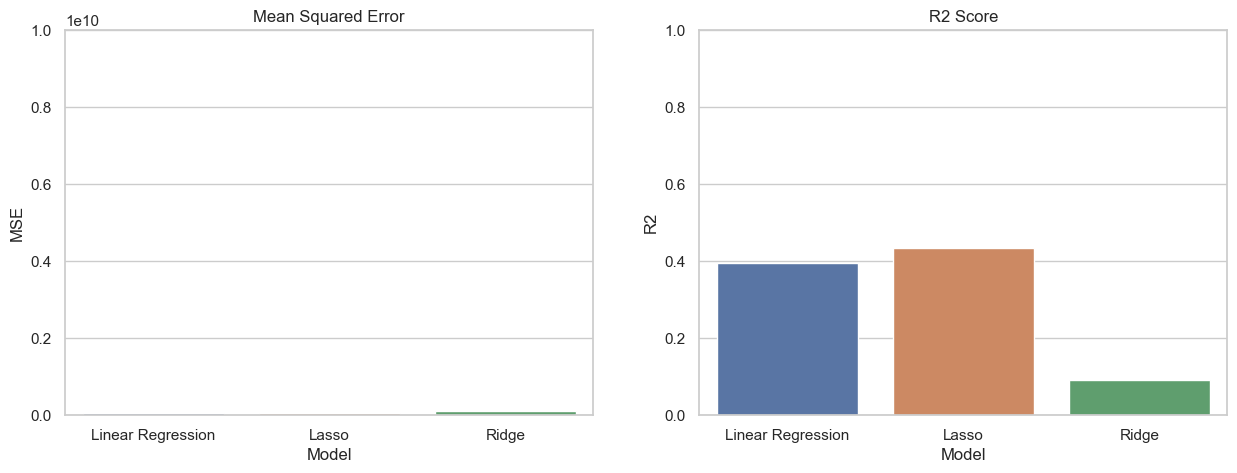

In [47]:

# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    
sns.barplot(x='Model', y='MSE', data=results_df, ax=axes[0])
axes[0].set_title('Mean Squared Error')
axes[0].set_ylim([0, 1e10])

sns.barplot(x='Model', y='R2', data=results_df, ax=axes[1])
axes[1].set_title('R2 Score')
axes[1].set_ylim([0, 1])

plt.show()


In [ ]:
# Cross validation to evaluate the models
from sklearn.model_selection import cross_val_score

cv_results = {'Model': [], 'CV Mean MSE': [], 'CV Mean R2': []}

for name, pipeline in pipelines.items():
    cv_mse = -cross_val_score(pipeline, X, y, cv=5, scoring='neg_mean_squared_error').mean()
    cv_r2 = cross_val_score(pipeline, X, y, cv=5, scoring='r2').mean()
    cv_results['Model'].append(name)
    cv_results['CV Mean MSE'].append(cv_mse)
    cv_results['CV Mean R2'].append(cv_r2)
    
cv_results_df = pd.DataFrame(cv_results)
print(cv_results_df)


D:\Anaconda\envs\UsedCarPricePrediction\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 161074442846.45544, tolerance: 313877743.5431812
  model = cd_fast.sparse_enet_coordinate_descent(
D:\Anaconda\envs\UsedCarPricePrediction\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:589: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 134758877574.58374, tolerance: 309335749.0963031
  model = cd_fast.sparse_enet_coordinate_descent(


In [ ]:
# Plot the cross validation results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x='Model', y='CV Mean MSE', data=cv_results_df, ax=axes[0])
axes[0].set_title('Cross Validation Mean Squared Error')
axes[0].set_ylim([0, 1e10])

sns.barplot(x='Model', y='CV Mean R2', data=cv_results_df, ax=axes[1])
axes[1].set_title('Cross Validation R2 Score')
axes[1].set_ylim([0, 1])

plt.show()



In [ ]:
# Hyperparameter tuning using GridSearchCV
from sklearn.model_selection import GridSearchCV

# Define the hyperparameters to tune
param_grids = {
    'Linear Regression': {},
    'Lasso': {'model__alpha': [0.1, 1, 10]},
    'Ridge': {'model__alpha': [0.1, 1, 10]}
}

# Create a dictionary of GridSearchCV objects
grid_searches = {}

for name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[name], cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X, y)
    grid_searches[name] = grid_search
    
    

In [ ]:
# Display the best hyperparameters for each model
for name, grid_search in grid_searches.items():
    print(f'{name}: {grid_search.best_params_}')
    
    

In [ ]:
# Evaluate the models with the best hyperparameters
best_results = {'Model': [], 'Best MSE': [], 'Best R2': []}

for name, grid_search in grid_searches.items():
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    best_results['Model'].append(name)
    best_results['Best MSE'].append(mse)
    best_results['Best R2'].append(r2)
    
best_results_df = pd.DataFrame(best_results)
print(best_results_df)


In [ ]:
# Plot the results
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

sns.barplot(x='Model', y='Best MSE', data=best_results_df, ax=axes[0])
axes[0].set_title('Best Mean Squared Error')
axes[0].set_ylim([0, 1e10])

sns.barplot(x='Model', y='Best R2', data=best_results_df, ax=axes[1])
axes[1].set_title('Best R2 Score')
axes[1].set_ylim([0, 1])

plt.show()


In [ ]:
# Save the best model
import joblib

best_model = grid_searches['Ridge']
joblib.dump(best_model, 'models/vehicle_price_prediction.pkl')



In [ ]:
# Load the model and make predictions
loaded_model = joblib.load('models/vehicle_price_prediction.pkl')
y_pred = loaded_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R2 Score: {r2}')



In [ ]:
# Display correlation matrix for numerical columns
corr_matrix = filtered_vehicles[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()


In [ ]:
# Display the feature importances for the best model
feature_names = numerical_cols + list(grid_searches['Ridge'].best_estimator_.named_steps['preprocessor'].transformers_[1][1].get_feature_names_out())
feature_importances = grid_searches['Ridge'].best_estimator_.named_steps['model'].coef_
feature_importances_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)
    
plt.figure(figsize=(5, 5))
sns.barplot(x='Importance', y='Feature', data=feature_importances_df)
plt.title('Feature Importances')
plt.show()



In [ ]:
# Which manufacturer has the highest average price?
manufacturer_prices = filtered_vehicles.groupby('manufacturer')['price'].mean().sort_values(ascending=False)
print(manufacturer_prices.head(1))


In [ ]:
# which features have the highest correlation with price?



filtered_vehicles.head()


In [ ]:
# Display most important features sorted by importance
feature_importances_df = feature_importances_df.sort_values('Importance', ascending=False)
print(feature_importances_df.head(10))



### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.


### Conclusion

In this notebook, we have explored the data, cleaned it, and built a model to predict the price of used vehicles. We have used multiple regression models and evaluated them using mean squared error and R2 score. We have also used cross validation and hyperparameter tuning to improve the models. Finally, we have saved the best model and made predictions on the test set. We have also analyzed the feature importances and identified the manufacturer with the highest average price.
Ridge regression model was the best model with the lowest mean squared error and highest R2 score. 
The most important features for predicting the price of a vehicle were the year, odometer, and the manufacturer. 
The manufacturer with the highest average price was tesla.


